# Predicting the next word

Create a model that will predict the next word in a text sequence, here it is implemented and trained using a corpus of Shakespeare's sonnets, while also creating some helper functions to pre-process the data.

In [18]:
import numpy as np 
from tensorflow.keras import regularizers
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.utils as ku 
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional



```
# This is formatted as code
```

Here the [Shakespeare Sonnets Dataset](https://www.opensourceshakespeare.org/views/sonnets/sonnet_view.php?range=viewrange&sonnetrange1=1&sonnetrange2=154), which contains more than 2000 lines of text extracted from Shakespeare's sonnets is used

In [19]:
# sonnets.txt
!gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: /content/sonnets.txt
100% 93.6k/93.6k [00:00<00:00, 81.9MB/s]


In [20]:
# Define path for file with sonnets
SONNETS_FILE = './sonnets.txt'

# Read the data
with open('./sonnets.txt') as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


## Tokenizing the text

Now fit the Tokenizer to the corpus and save the total number of words.

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [22]:
corpus[0]

'from fairest creatures we desire increase,'

In [25]:
tokenizer.texts_to_sequences([corpus[0]])[0]

[34, 417, 877, 166, 213, 517]

## Generating n_grams

Now complete the `n_gram_seqs` function below. This function receives the fitted tokenizer and the corpus (which is a list of strings) and should return a list containing the `n_gram` sequences for each line in the corpus:

In [26]:
# GRADED FUNCTION: n_gram_seqs
def n_gram_seqs(corpus, tokenizer):
    """
    Generates a list of n-gram sequences
    
    Args:
        corpus (list of string): lines of texts to generate n-grams for
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    
    Returns:
        input_sequences (list of int): the n-gram sequences for each line in the corpus
    """
    input_sequences = []
    
    ### START CODE HERE
    for line in corpus:
      token_list = tokenizer.texts_to_sequences([line])[0]
      for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
    
    ### END CODE HERE
    
    return input_sequences

In [27]:
# Testing function with one example
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

In [28]:
# Testing function with a bigger corpus
next_3_examples_sequence = n_gram_seqs(corpus[1:4], tokenizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:



[[8, 878],
 [8, 878, 134],
 [8, 878, 134, 351],
 [8, 878, 134, 351, 102],
 [8, 878, 134, 351, 102, 156],
 [8, 878, 134, 351, 102, 156, 199],
 [16, 22],
 [16, 22, 2],
 [16, 22, 2, 879],
 [16, 22, 2, 879, 61],
 [16, 22, 2, 879, 61, 30],
 [16, 22, 2, 879, 61, 30, 48],
 [16, 22, 2, 879, 61, 30, 48, 634],
 [25, 311],
 [25, 311, 635],
 [25, 311, 635, 102],
 [25, 311, 635, 102, 200],
 [25, 311, 635, 102, 200, 25],
 [25, 311, 635, 102, 200, 25, 278]]

Apply the `n_gram_seqs` transformation to the whole corpus and save the maximum sequence length to use it later:

In [29]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length 
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15462
maximum length of sequences is: 11


## Add padding to the sequences

Now code the `pad_seqs` function which will pad any given sequences to the desired maximum length. Notice that this function receives a list of sequences and should return a numpy array with the padded sequences: 

In [30]:
# GRADED FUNCTION: pad_seqs
def pad_seqs(input_sequences, maxlen):
    """
    Pads tokenized sequences to the same length
    
    Args:
        input_sequences (list of int): tokenized sequences to pad
        maxlen (int): maximum length of the token sequences
    
    Returns:
        padded_sequences (array of int): tokenized sequences padded to the same length
    """
    ### START CODE HERE
    max_sequence_len = max([len(x) for x in input_sequences])
    padded_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    return padded_sequences
    ### END CODE HERE

In [31]:
# Test your function with the n_grams_seq of the first example
first_padded_seq = pad_seqs(first_example_sequence, len(first_example_sequence))
first_padded_seq

array([[  0,   0,   0,   0,  34, 417],
       [  0,   0,   0,  34, 417, 877],
       [  0,   0,  34, 417, 877, 166],
       [  0,  34, 417, 877, 166, 213],
       [ 34, 417, 877, 166, 213, 517]], dtype=int32)

In [32]:
# Test your function with the n_grams_seq of the next 3 examples
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[  0,   0,   0,   0,   0,   0,   8, 878],
       [  0,   0,   0,   0,   0,   8, 878, 134],
       [  0,   0,   0,   0,   8, 878, 134, 351],
       [  0,   0,   0,   8, 878, 134, 351, 102],
       [  0,   0,   8, 878, 134, 351, 102, 156],
       [  0,   8, 878, 134, 351, 102, 156, 199],
       [  0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,  16,  22,   2, 879,  61],
       [  0,   0,  16,  22,   2, 879,  61,  30],
       [  0,  16,  22,   2, 879,  61,  30,  48],
       [ 16,  22,   2, 879,  61,  30,  48, 634],
       [  0,   0,   0,   0,   0,   0,  25, 311],
       [  0,   0,   0,   0,   0,  25, 311, 635],
       [  0,   0,   0,   0,  25, 311, 635, 102],
       [  0,   0,   0,  25, 311, 635, 102, 200],
       [  0,   0,  25, 311, 635, 102, 200,  25],
       [  0,  25, 311, 635, 102, 200,  25, 278]], dtype=int32)

In [33]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15462, 11)


## Split the data into features and labels

Before feeding the data into the neural network you should split it into features and labels. In this case the features will be the padded n_gram sequences with the last word removed from them and the labels will be the removed word.

`features_and_labels` function : This function expects the padded n_gram sequences as input and should return a tuple containing the features and the one hot encoded labels.


In [34]:
# GRADED FUNCTION: features_and_labels
def features_and_labels(input_sequences, total_words):
    """
    Generates features and labels from n-grams
    
    Args:
        input_sequences (list of int): sequences to split features and labels from
        total_words (int): vocabulary size
    
    Returns:
        features, one_hot_labels (array of int, array of int): arrays of features and one-hot encoded labels
    """
    ### START CODE HERE
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = ku.to_categorical(labels, num_classes=total_words)
    ### END CODE HERE

    return features, one_hot_labels

In [35]:
# Test your function with the padded n_grams_seq of the first example
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}")
print("\nfeatures look like this:\n")
first_features

labels have shape: (5, 3211)

features look like this:



array([[  0,   0,   0,   0,  34],
       [  0,   0,   0,  34, 417],
       [  0,   0,  34, 417, 877],
       [  0,  34, 417, 877, 166],
       [ 34, 417, 877, 166, 213]], dtype=int32)

In [36]:
# Split the whole corpus
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


## Create the model

Model architecture should be capable of achieving an accuracy of at least 80%.

- An appropriate `output_dim` for the first layer (Embedding) is 100, this is already provided for you.
- A Bidirectional LSTM is helpful for this particular problem.
- The last layer should have the same number of units as the total number of words in the corpus and a softmax activation function.
- This problem can be solved with only two layers (excluding the Embedding) so try out small architectures first.

In [39]:
# GRADED FUNCTION: create_model
def create_model(total_words, max_sequence_len):
    """
    Creates a text generator model
    
    Args:
        total_words (int): size of the vocabulary for the Embedding layer input
        max_sequence_len (int): length of the input sequences
    
    Returns:
        model (tf.keras Model): the text generator model
    """
    model = Sequential()
    ### START CODE HERE
    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1)) # Your Embedding Layer)
    model.add(Bidirectional(LSTM(100, return_sequences = True)))            # An LSTM Layer)
    model.add(Dropout(0.2))                                                # A dropout layer)
    model.add(Bidirectional(LSTM(100)))                                     # Another LSTM Layer)
    model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))      # A Dense Layer including regularizers)
    model.add(Dense(total_words, activation='softmax'))                    # A Dense Layer)
    # Pick an optimizer
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])# Pick a loss function and an optimizer)

    ### END CODE HERE

    return model

In [40]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)

# Train the model
history = model.fit(features, labels, epochs=140, verbose=1)

Epoch 1/140
484/484 [==============================] - 16s 12ms/step - loss: 6.9715 - accuracy: 0.0205
Epoch 2/140
484/484 [==============================] - 6s 12ms/step - loss: 6.5179 - accuracy: 0.0216
Epoch 3/140
484/484 [==============================] - 6s 12ms/step - loss: 6.4133 - accuracy: 0.0229
Epoch 4/140
484/484 [==============================] - 6s 12ms/step - loss: 6.2877 - accuracy: 0.0287
Epoch 5/140
484/484 [==============================] - 6s 12ms/step - loss: 6.1873 - accuracy: 0.0350
Epoch 6/140
484/484 [==============================] - 6s 12ms/step - loss: 6.0947 - accuracy: 0.0384
Epoch 7/140
484/484 [==============================] - 7s 15ms/step - loss: 5.9951 - accuracy: 0.0407
Epoch 8/140
484/484 [==============================] - 7s 14ms/step - loss: 5.8795 - accuracy: 0.0448
Epoch 9/140
484/484 [==============================] - 6s 12ms/step - loss: 5.7521 - accuracy: 0.0526
Epoch 10/140
484/484 [==============================] - 6s 12ms/step - loss: 5.63

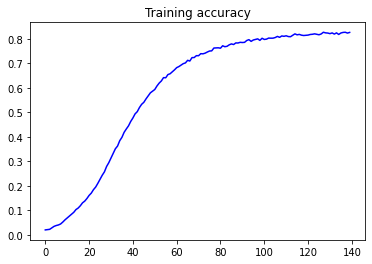

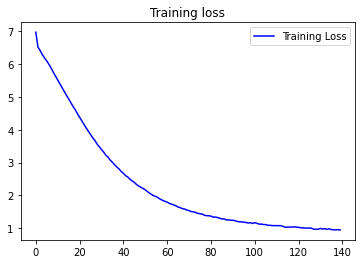

In [41]:
# Take a look at the training curves of your model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [42]:
def download_history():
  import pickle
  from google.colab import files

  with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## See model in action

Run the cell below to generate the next 100 words of a seed text.

In [44]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	# Convert the text into sequences
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	# Pad the sequences
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	# Get the probabilities of predicting a word
	predicted = model.predict(token_list, verbose=0)
	# Choose the next word based on the maximum probability
	predicted = np.argmax(predicted, axis=-1).item()
	# Get the actual word from the word index
	output_word = tokenizer.index_word[predicted]
	# Append to the current text
	seed_text += " " + output_word

print(seed_text)

Help me Obi Wan Kenobi, you're my only hope name they buried of life tell mine eyes common grow on earth nearly hour such summer's gait treason cold holds from men away ' back again shall play to stand cold cold doth date disarm'd disarm'd set dead burn her heart torn seen releasing far mad fix'd so better air in no lips more write to you best best so show thee thine old old rent near slain near wilt shine bright lies free seen weep held weep new bold eye on nought better hate on ' alone so seen another youth and life i shows not they lie to
